In [1]:
import  urllib
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import requests
import json
import io
import csv
import shapely
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import shapely
from fiona.crs import from_epsg

In [3]:
import seaborn as sns

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

In [5]:
from censusAPI import myAPI

In [6]:
import statsmodels.formula.api as smf

In [7]:
#for modeling
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingClassifier as gdb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA

## 1. Collect the school related data

### Collect School SAT data 

### read in the SAT scores for NYC schools

In [8]:
url = 'https://data.cityofnewyork.us/resource/734v-jeq5.csv'
pd.read_csv(url).to_csv('2012_SAT_Results.csv')

In [9]:
os.system("mv " + "2012_SAT_Results.csv " + os.getenv("PUIDATA"))

0

In [10]:
sat_big = pd.read_csv(os.getenv("PUIDATA") + "/" +'2012_SAT_Results.csv', na_values = 's')[['dbn',
                                                                                       'num_of_sat_test_takers',
                                                                                       'sat_critical_reading_avg_score',
                                                                                       'sat_math_avg_score','sat_writing_avg_score']]

In [11]:
len(sat_big)

478

In [201]:
# sat['sat_math_avg_score'] = sat['sat_math_avg_score'].astype(float)

### create a new feature: SAT all

In [12]:
sat_big['SATall'] = (sat_big['sat_math_avg_score'] + sat_big['sat_critical_reading_avg_score']
                 + sat_big['sat_writing_avg_score']) / 3

In [13]:
sat_big.rename(columns={'dbn': 'DBN', 'sat_math_avg_score': 'SATmath'}, inplace = True)

# FBB good

### Only using part of the columns, so I create another dataframe"

In [14]:
sat = sat_big[['DBN', 'SATmath', 'SATall']]
sat.to_csv('satScoresNYC.csv', index=False)
os.system("mv " + "satScoresNYC.csv " + os.getenv("PUIDATA"))

0

In [15]:
sat.head()

,DBN,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


### 1.2 Collect school crime data

### Read in the NYPD crimes in school report

In [16]:
url_school_crime = 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD'
pd.read_csv(url_school_crime).to_csv('School_Safety_Report.csv')
os.system("mv " + "School_Safety_Report.csv " + os.getenv("PUIDATA"))

0

In [17]:
school_crime = pd.read_csv(os.getenv("PUIDATA") + "/" +'School_Safety_Report.csv')

In [18]:
len(school_crime)

6310

### Inspect the distribution of crimes per school

In [19]:
school_crime.columns

Index(['Unnamed: 0', 'School Year', 'Building Code', 'DBN', 'Location Name',
       'Location Code', 'Address', 'Borough', 'Geographical District Code',
       'Register', 'Building Name', '# Schools', 'Schools in Building',
       'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Borough Name', 'Postcode', 'Latitude', 'Longitude',
       'Community Board', 'Council District ', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


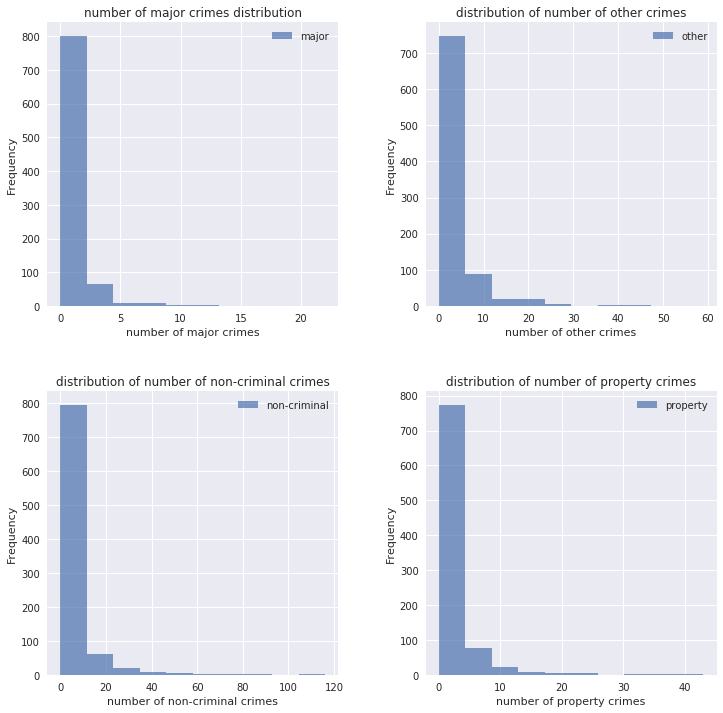

In [27]:
plt.figure(figsize=(12,12))
plt.plot([2,2])
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.subplot(221)
plt.hist(school_crime.groupby('DBN').sum()['Major N'].dropna(), alpha=0.7, label='major')
plt.title('number of major crimes distribution')
plt.xlabel('number of major crimes')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(222)
plt.hist(school_crime.groupby('DBN').sum()['Oth N'].dropna(), alpha=0.7, label='other')
plt.title('distribution of number of other crimes')
plt.xlabel('number of other crimes')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(223)
plt.hist(school_crime.groupby('DBN').sum()['NoCrim N'].dropna(), alpha=0.7, label='non-criminal')
plt.title('distribution of number of non-criminal crimes')
plt.xlabel('number of non-criminal crimes')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(224)
plt.hist(school_crime.groupby('DBN').sum()['Prop N'].dropna(), alpha=0.7, label='property')
plt.title('distribution of number of property crimes')
plt.xlabel('number of property crimes')
plt.ylabel('Frequency')
plt.legend()

### Figure 1: 
Group the pandas dataframe by 'DBN'. 
The plot is the distribution of crimes per school.  X-axis is the number of different kinds of crimes. Y-axis is the number of school that has the given amount of crimes. According to the distribution histogram. The distribution of major/other/non-criminal/property crimes are roughly the same. Most schools have less than 5 crimes. Some has a lot more. Note that some schools have the same 'DBN', the number of crimes per 'DBN' is the sum of all the number of crimes in this 'DBN'

# FBB task 1 10/10

### plot the distribution of "Average number of Major crimes' by school

Text(0,0.5,'Frequency')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


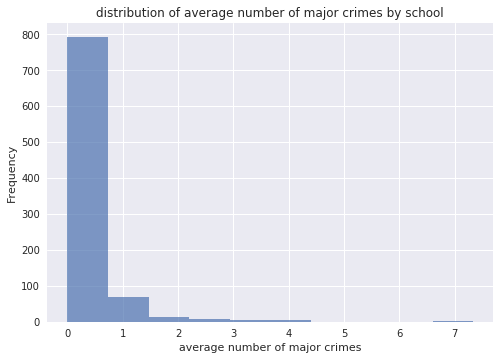

In [210]:
plt.hist(school_crime.groupby('DBN').mean()['Major N'].dropna(), alpha=0.7, label='other')
plt.title('distribution of average number of major crimes by school')
plt.xlabel('average number of major crimes')
plt.ylabel('Frequency')

### Figure 2:
Group the pandas dataframe by 'DBN'. The plot is the distribution of 'Average number of Major crimes' by school dbn. X-axis is the average of number of major crimes. Y-axis is the number of school that has the given amount of mean crimes. According to the distribution histogram. Most of the average number of major crimes are less than 1.

## 2. Merge school crime and SAT data

This is the original shape of the data I downloaded

In [28]:
print("crime schools DF shape", school_crime.shape, "SAT schools DF shape", sat.shape)

crime schools DF shape (6310, 35) SAT schools DF shape (478, 3)


### Fill in the missing data: the school with no crimes are not included in the school_crime database, so assume that there were 0 crimes

In [29]:
values = {'AvgOfMajor N': 0, 'AvgOfOth N': 0, 'AvgOfNoCrim N': 0, 'AvgOfProp N': 0,
       'AvgOfVio N': 0,'Major N': 0, 'Oth N': 0, 'NoCrim N': 0, 'Prop N': 0, 'Vio N': 0}
school_crime = school_crime.fillna(value=values).dropna(subset=['DBN'])

In [30]:
school_crime.shape

(5308, 35)

The shape of school_crime decreases because I drop the row that the value in 'DBN' is NAN.
There is no missing value in 'DBN' in sat dataframe

If the SAT score is missing, it is not resonable to fill it with 0. It is also not resonable to fill the missing value by 'backfill' or any other method since two schools near each other can have very different SAT performances. (For example, Manhattan Midtown and East Harlem are totally different neighborhoods but they are very close to each other)

The length of sat dataframe decreased after I drop missing values

In [31]:
sat = sat.dropna()

In [33]:
sat.shape

(421, 3)

### Merge the SAT and the crime in school data based on 'DBN'

In [34]:
schools = school_crime.merge(sat, on='DBN', how='inner')

In [35]:
schools.shape

(1202, 37)

The size of my dataframe further decreased because some 'DBN' only has crime data but has no SAT data. The inner method preserves the order of the left keys (in school_crime). Note that different schools may have the same 'DBN', so the 'DBN' column in school_crime dataframe may duplicate.

In [36]:
schools = schools[['AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
         'DBN', 'Latitude', 'Longitude', 'SATmath', 'SATall']].dropna(subset=['DBN'])

In [37]:
schools.head()

,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Major N,Oth N,NoCrim N,Prop N,Vio N,DBN,Latitude,Longitude,SATmath,SATall
0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,16K393,40.692126,-73.931731,355.0,356.0
1,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,16K393,40.692126,-73.931731,355.0,356.0
2,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,16K393,40.692126,-73.931731,355.0,356.0
3,0.33,1.32,1.76,0.83,0.59,0.0,0.0,0.0,0.0,0.0,02M418,40.704487,-74.011556,553.0,538.0
4,0.31,1.12,1.82,0.79,0.51,0.0,0.0,0.0,0.0,0.0,02M418,40.704487,-74.011556,553.0,538.0


In [224]:
schools.shape

(1202, 15)

### Multiple schools in a single building: Count the individual school location

In [38]:
schools.groupby(['Latitude','Longitude']).count()[['DBN']].reset_index().head()

,Latitude,Longitude,DBN
0,40.528092,-74.192032,6
1,40.567873,-74.115373,3
2,40.569393,-74.107737,3
3,40.577208,-73.985953,3
4,40.580894,-73.935952,3


### Implication: 

Some schools are in the same building, so the column 'DBN' duplicates in my dataframe after merge because there are more than one school in a single building ("DBN")

## 3. Visualize:

### 3.1 plot the Math SAT score and the average of all SAT scores as a function of two crime statistics

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


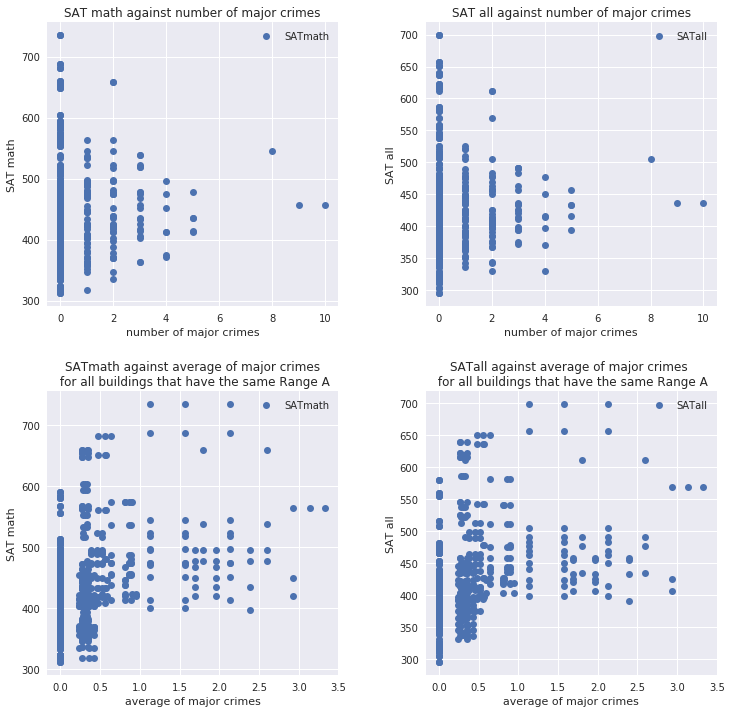

In [39]:
plt.figure(figsize=(12,12))
plt.plot([2,2])
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.subplot(221)
plt.plot(schools['Major N'], schools['SATmath'],'o', label='SATmath')
plt.title('SAT math against number of major crimes')
plt.xlabel('number of major crimes')
plt.ylabel('SAT math')
plt.legend()
plt.subplot(222)
plt.plot(schools['Major N'], schools['SATall'],'o', label='SATall')
plt.title('SAT all against number of major crimes')
plt.xlabel('number of major crimes')
plt.ylabel('SAT all')
plt.legend()
plt.subplot(223)
plt.plot(schools['AvgOfMajor N'], schools['SATmath'],'o', label='SATmath')
plt.title('SATmath against average of major crimes\n for all buildings that have the same Range A')
plt.xlabel('average of major crimes')
plt.ylabel('SAT math')
plt.legend()
plt.subplot(224)
plt.plot(schools['AvgOfMajor N'], schools['SATall'],'o', label='SATall')
plt.title('SATall against average of major crimes \n for all buildings that have the same Range A')
plt.xlabel('average of major crimes')
plt.ylabel('SAT all')
plt.legend()

## Figure 3:
The plot of SAT math against the number of major crimes/ SAT all against the number of major crimes/ SAT math against average of major crimes for all buildings that have the same Range A/ SAT all against average of major crimes for all buildings that have the same Range A.

As is shown in this plot, it is strange that when the number of crimes is high, the SAT score also distributes at a higher range. Note that the number of crimes is integers. 


# FBB also worth noticing how similar the SAT math and SAT all plots are (also the caption should say what SAT math and SAT all is!!)

# task 2 10/10

### 3.2 Create geometry from the lat-lon coordinates and map the location of each school in the dataset

In [40]:
schools.columns

Index(['AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'DBN',
       'Latitude', 'Longitude', 'SATmath', 'SATall'],
      dtype='object')

In [41]:
schools['lonlat'] = list(zip(schools.Longitude, schools.Latitude))
schools['geometry'] = schools[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
schools = gpd.GeoDataFrame(schools)
schools.head()

,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Major N,Oth N,NoCrim N,Prop N,Vio N,DBN,Latitude,Longitude,SATmath,SATall,lonlat,geometry
0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,16K393,40.692126,-73.931731,355.0,356.0,"(-73.931731, 40.692126)",POINT (-73.931731 40.692126)
1,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,16K393,40.692126,-73.931731,355.0,356.0,"(-73.931731, 40.692126)",POINT (-73.931731 40.692126)
2,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,16K393,40.692126,-73.931731,355.0,356.0,"(-73.931731, 40.692126)",POINT (-73.931731 40.692126)
3,0.33,1.32,1.76,0.83,0.59,0.0,0.0,0.0,0.0,0.0,02M418,40.704487,-74.011556,553.0,538.0,"(-74.011556, 40.704487)",POINT (-74.011556 40.704487)
4,0.31,1.12,1.82,0.79,0.51,0.0,0.0,0.0,0.0,0.0,02M418,40.704487,-74.011556,553.0,538.0,"(-74.011556, 40.704487)",POINT (-74.011556 40.704487)


### To make the map more clear, I put the points on a NYC map. To plot them, I transformed them into state plane coordinates

In [42]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
!unzip -d $PUIDATA file.gz


Archive:  file.gz
  inflating: /nfshome/bl2621/PUIdata/geo_export_5a511cf9-c7b2-43ca-b998-b9dec23a4240.dbf  
  inflating: /nfshome/bl2621/PUIdata/geo_export_5a511cf9-c7b2-43ca-b998-b9dec23a4240.shp  
  inflating: /nfshome/bl2621/PUIdata/geo_export_5a511cf9-c7b2-43ca-b998-b9dec23a4240.shx  
  inflating: /nfshome/bl2621/PUIdata/geo_export_5a511cf9-c7b2-43ca-b998-b9dec23a4240.prj  


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(905464.73903808615,
 1075092.8783935562,
 112485.76063499099,
 280480.41425937973)

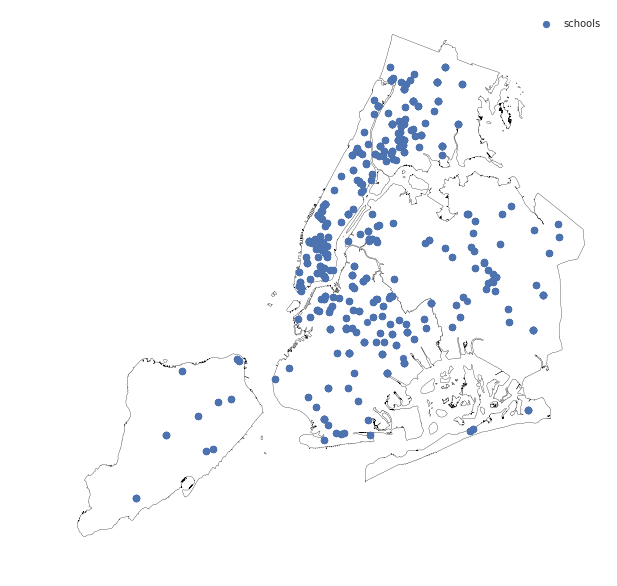

In [43]:
boro = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                 "/geo_export_5a511cf9-c7b2-43ca-b998-b9dec23a4240.shp")
boro.to_crs(epsg=2263, inplace=True)
schools.crs = from_epsg(4326)
schools = schools.to_crs(epsg=2263)
ax = boro.plot(figsize = (10,15), facecolor="w", edgecolor="k")
schools.plot(ax=ax)
ax.legend(['schools'])
ax.axis("off")

## Figure 4:
Map the location of each school in the dataset. The points are plotted on a NYC map. As is shown in the plot, most of the school lies in Manhattan and Brooklyn.

# FBB task 3 10/10

## 4. Gather Asthma and drugs hospital discharge

### 4.1.Read in the SPARCS data

### read in the SPARCS data

In [44]:
url_health = 'https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD'

In [45]:
# urllib.request.urlretrieve(url_health, "Hospital_Inpatient_Discharges__SPARCS_De-Identified___2012.csv")
# os.system("mv " + "Hospital_Inpatient_Discharges__SPARCS_De-Identified___2012.csv " + os.getenv("PUIDATA"))
# SPARCS = pd.read_csv(os.getenv("PUIDATA") + "/" +'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2012.csv')

In [46]:
SPARCS = pd.read_csv(url_health)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
print('The shape of the data I read in is ',len(SPARCS))

The shape of the data I read in is  2544543


The number of discharges in the original data set is 2544543

### Throw away the data that is not in NYC by county names

In [49]:
SPARCS_NY = SPARCS[(SPARCS['Hospital County'] == 'Kings') | (SPARCS['Hospital County'] == 'Queens') 
| (SPARCS['Hospital County'] == 'Manhattan') 
| (SPARCS['Hospital County'] == 'Bronx')
| (SPARCS['Hospital County'] == 'Richmond')]

In [51]:
SPARCS_NY.head(2)

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
954417,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,F,Black/African American,Not Span/Hispanic,...,Medicaid,NaN,197201.0,NaN,NaN,0,N,Y,10408.87,8618.38
954464,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,NaN,186946.0,NaN,NaN,0,N,Y,4652.69,3852.35


In [52]:
nd = len(SPARCS_NY)
print("number of NYC discharges", nd)

number of NYC discharges 1199520


After I throw away all the discharges that are not in NYC, I have 1199520 discharges in my dataset.

### 4.2  calculate the fraction of asthma and drug related diagnoses per facility

### count the number of asthma and drup related diagnoses per facility:

In [53]:
nycF = len(SPARCS_NY['Facility ID'].unique())
print("number of NYC facilities in the dataset", nycF)

number of NYC facilities in the dataset 61


In [54]:
nyca = len(SPARCS_NY[(SPARCS_NY['CCS Diagnosis Description'] == 'Asthma') 
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)')
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Respiratory distress syndrome')])
print("number of asthma related cases in NYC", nyca) 

number of asthma related cases in NYC 30717


In [55]:
nycd = len(SPARCS_NY[(SPARCS_NY['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents') 
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Alcohol-related disorders')
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Substance-related disorders')])
print("number of drug related cases in NYC", nycd)

number of drug related cases in NYC 46336


### Calculate the ratio

In [56]:
discharge = pd.DataFrame()
discharge['Permananet Facility ID'] = SPARCS_NY.groupby('Facility ID').groups.keys()

In [57]:
def asthma_of_ID(ids):
    asthma_of_ID = len(SPARCS_NY[(SPARCS_NY['Facility ID'] == ids) & 
    ((SPARCS_NY['CCS Diagnosis Description'] == 'Asthma') 
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)')
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Respiratory distress syndrome'))])

    total_of_ID = len(SPARCS_NY[(SPARCS_NY['Facility ID'] == ids)])
    
    return (asthma_of_ID / total_of_ID)


In [58]:
def drugs_of_ID(ids):
    drugs_of_ID = len(SPARCS_NY[(SPARCS_NY['Facility ID'] == ids) & 
    ((SPARCS_NY['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents') 
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Alcohol-related disorders')
       |(SPARCS_NY['CCS Diagnosis Description'] == 'Substance-related disorders'))])
    
    total_of_ID = len(SPARCS_NY[(SPARCS_NY['Facility ID'] == ids)])
    
    return (drugs_of_ID / total_of_ID)

In [59]:
discharge['asthmaRatio'] = discharge['Permananet Facility ID'].apply(asthma_of_ID)
discharge['drugsRatio'] = discharge['Permananet Facility ID'].apply(drugs_of_ID)

In [60]:
discharge.to_csv(os.getenv("PUIDATA")+'/discharge.csv', index=False)
discharge.head()

,Permananet Facility ID,asthmaRatio,drugsRatio
0,1286.0,0.054538,0.011223
1,3975.0,0.030642,0.014279
2,1288.0,0.036174,0.043442
3,1164.0,0.000000,0.485865
4,1165.0,0.053588,0.061033


In [61]:
discharge.shape

(61, 3)

For every facilities, I have asthmaRatio and DrugsRatio. The size of my discharge dataframe == the number of NYC facilities in the SPARCS dataset

### 4.3 Find the location of each facility:

In [62]:
API_URL = 'https://fb55.carto.com:443/api/v2/sql?q='

def queryCartoDB(query, formatting = 'CSV', source = API_URL):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io.BytesIO(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [63]:
query = '''
SELECT * FROM nyc_facilities
'''
table = get_data(query)
table.head(3)

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"


number of facilities in this data base

In [64]:
len(table)

1275

Merge this database with discharge data frame

In [65]:
discharge_loc = discharge.merge(table, left_on='Permananet Facility ID', right_on='facility_id', how='left')

In [66]:
len(discharge_loc)

61

There are 61 facilities left after merge. Although in the nyc_facilities DataBase, there are 1275 facilities that we have the location information, we don't have the asthmaRatio information in the discharge dataframe, so these facilities will be discarded after merge. Furthermore, all the facilities in my 'discharge' dataframe can find the location information.

In [67]:
discharge_loc.head(3)

,Permananet Facility ID,asthmaRatio,drugsRatio,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,1286.0,0.054538,0.011223,0101000020E61000000C01C0B1677A52C05B5CE333D953...,Metropolitan Area Regional Office - New York City,0101000020110F0000D57014AA11635FC11642B1154FED...,1286.0,Brookdale Hospital Medical Center,HOSP,Hospital,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.655066,-73.912579,"(40.655066, -73.912579)"
1,3975.0,0.030642,0.014279,0101000020E6100000FFEA71DF6A7A52C0EFC9C342AD6F...,Metropolitan Area Regional Office - New York City,0101000020110F00003AFF381017635FC1A837727A830C...,3975.0,New York Presbyterian Hospital - Allen Hospital,HOSP,Hospital,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.872475,-73.912773,"(40.872475, -73.912773)"
2,1288.0,0.036174,0.043442,0101000020E6100000F2936A9F8E7E52C020B41EBE4C58...,Metropolitan Area Regional Office - New York City,0101000020110F0000B9E5BA271F6A5FC1F0BA9C204BF2...,1288.0,Brooklyn Hospital Center - Downtown Campus,HOSP,Hospital,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.689842,-73.977455,"(40.689842, -73.977455)"


# FBB task 4 10/10

## 5.Aggregate at the PUMA level

### 5.1 getting PUMA geodata

In [68]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7fdb8ebbc5c0>)

In [69]:
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /nfshome/bl2621/PUIdata/geo_export_a568e089-0537-4b30-ae19-f9a7e1a2d26c.dbf  
  inflating: /nfshome/bl2621/PUIdata/geo_export_a568e089-0537-4b30-ae19-f9a7e1a2d26c.shp  
  inflating: /nfshome/bl2621/PUIdata/geo_export_a568e089-0537-4b30-ae19-f9a7e1a2d26c.shx  
  inflating: /nfshome/bl2621/PUIdata/geo_export_a568e089-0537-4b30-ae19-f9a7e1a2d26c.prj  


In [70]:
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
                                     "geo_export_a568e089-0537-4b30-ae19-f9a7e1a2d26c.shp")

In [71]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [72]:
len(pumashp)

55

There are 55 PUMA areas in NYC

In [73]:
pumashp.crs

{'init': 'epsg:4326'}

In [74]:
discharge_loc['facility_location'] = list(zip(discharge_loc.facility_longitude, discharge_loc.facility_latitude))
discharge_loc['geometry'] = discharge_loc[['facility_location']].applymap(lambda x:shapely.geometry.Point(x))
discharge_loc = gpd.GeoDataFrame(discharge_loc)
discharge_loc.head()

,Permananet Facility ID,asthmaRatio,drugsRatio,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,...,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location,geometry
0,1286.0,0.054538,0.011223,0101000020E61000000C01C0B1677A52C05B5CE333D953...,Metropolitan Area Regional Office - New York City,0101000020110F0000D57014AA11635FC11642B1154FED...,1286.0,Brookdale Hospital Medical Center,HOSP,Hospital,...,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.655066,-73.912579,"(-73.912579, 40.655066)",POINT (-73.91257900000001 40.655066)
1,3975.0,0.030642,0.014279,0101000020E6100000FFEA71DF6A7A52C0EFC9C342AD6F...,Metropolitan Area Regional Office - New York City,0101000020110F00003AFF381017635FC1A837727A830C...,3975.0,New York Presbyterian Hospital - Allen Hospital,HOSP,Hospital,...,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.872475,-73.912773,"(-73.912773, 40.872475)",POINT (-73.912773 40.872475)
2,1288.0,0.036174,0.043442,0101000020E6100000F2936A9F8E7E52C020B41EBE4C58...,Metropolitan Area Regional Office - New York City,0101000020110F0000B9E5BA271F6A5FC1F0BA9C204BF2...,1288.0,Brooklyn Hospital Center - Downtown Campus,HOSP,Hospital,...,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.689842,-73.977455,"(-73.977455, 40.689842)",POINT (-73.97745500000001 40.689842)
3,1164.0,0.000000,0.485865,0101000020E610000063B5F97FD57952C040DD4081776A...,Metropolitan Area Regional Office - New York City,0101000020110F0000B6B6A25619625FC1D23F8EE9A906...,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,HOSP,Hospital,...,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.831772,-73.903656,"(-73.903656, 40.831772)",POINT (-73.90365600000001 40.83177199999999)
4,1165.0,0.053588,0.061033,0101000020E6100000ABCB2901317652C0CEFDD5E3BE6D...,Metropolitan Area Regional Office - New York City,0101000020110F00004912B666E95B5FC102184048580A...,1165.0,Jacobi Medical Center,HOSP,Hospital,...,NaN,NaN,NaN,New York,NaN,Municipality,40.857388,-73.846741,"(-73.846741, 40.857388)",POINT (-73.84674100000001 40.857388)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


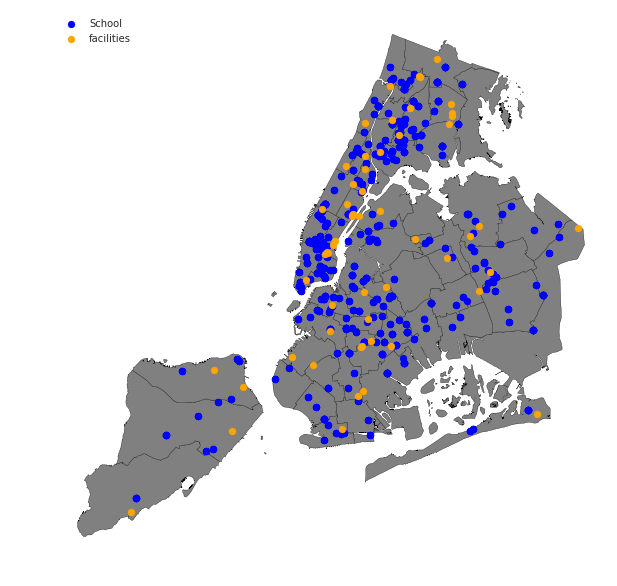

In [75]:
# pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
#                                      "geo_export_ec2c8fe4-c855-4089-aea8-db3ec95c1f2b.shp")
pumashp.to_crs(epsg=2263, inplace=True)
discharge_loc.crs = from_epsg(4326)
discharge_loc = discharge_loc.to_crs(epsg=2263)
ax = pumashp.plot(figsize = (10,15), facecolor="grey", edgecolor="k")
schools.plot(ax=ax, color='blue')
discharge_loc.plot(ax=ax, color='orange')
ax.legend(['School','facilities'], loc = 'upper left')
ax.axis("off")
plt.show()

### Fig.5: 
The NYC Public Use Microdata Areas (PUMAs). NYC is divided into 55 PUMAs ranging in size reflecting the population density variations in NYC (since PUMAs are constructed to collect a fix number of inhabitants).
Orange dots represents facilities. Blue dots here represents schools.

# FBB ok

### 5.2  Join hospital facilities and PUMA data

In [76]:
len(pumashp)

55

In [77]:
len(discharge_loc)

61

In [78]:
PUMA_faci = gpd.sjoin(pumashp, discharge_loc, op='contains')[['puma', 'asthmaRatio', 'drugsRatio']]

In [79]:
PUMA_faci = PUMA_faci.groupby('puma').mean()

the asthmaRatio and the drugnsRatio averaged by PUMA

In [80]:
len(PUMA_faci)

38

After the spacial join, only 38 PUMA areas has discharge facilities

In [81]:
PUMA_faci.head()

,asthmaRatio,drugsRatio
puma,,
3702,0.036503,0.063314
3704,0.027440,0.021513
3705,0.022103,0.344390
3706,0.038256,0.013680
3707,0.054454,0.013583


### 5.3  join school data and puma

In [82]:
PUMA_school_latlon = gpd.sjoin(pumashp, schools, op='contains')

In [83]:
PUMA_school = PUMA_school_latlon.drop(['shape_area','shape_leng','geometry',
                                'index_right','DBN','lonlat','Latitude', 'Longitude'],axis=1)

In [84]:
PUMA_school.columns

Index(['puma', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'SATmath', 'SATall'],
      dtype='object')

In [85]:
PUMA_school = PUMA_school.groupby('puma').mean().fillna(0)

Average on a PUMA level

In [86]:
PUMA_school.head()

,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Major N,Oth N,NoCrim N,Prop N,Vio N,SATmath,SATall
puma,,,,,,,,,,,,
3701,0.288788,1.321515,2.244242,0.813939,0.544242,0.030303,0.818182,1.696970,0.454545,0.151515,443.363636,430.363636
3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741
3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000
3704,0.062143,0.237857,0.343571,0.161429,0.107857,0.000000,1.500000,0.928571,0.785714,0.571429,424.428571,414.976190
3705,0.058462,0.218718,0.325000,0.147692,0.100641,0.192308,1.025641,1.679487,0.448718,0.500000,379.115385,374.068376


In [87]:
len(PUMA_school)

53

After the spacial join, only 53 PUMA areas has school crime informations

In [88]:
alldata = PUMA_school.merge(PUMA_faci, left_index=True, right_index=True).reset_index()

In [89]:
len(alldata)

37

37 PUMA areas in the final data set. 37 PUMA areas has both school crime information and discharge facilities

In [90]:
alldata.head()

,puma,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Major N,Oth N,NoCrim N,Prop N,Vio N,SATmath,SATall,asthmaRatio,drugsRatio
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.036503,0.063314
1,3704,0.062143,0.237857,0.343571,0.161429,0.107857,0.000000,1.500000,0.928571,0.785714,0.571429,424.428571,414.976190,0.027440,0.021513
2,3705,0.058462,0.218718,0.325000,0.147692,0.100641,0.192308,1.025641,1.679487,0.448718,0.500000,379.115385,374.068376,0.022103,0.344390
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.054454,0.013583
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,368.233333,359.777778,0.057007,0.003671


# FBB task 5 10/10

## Extra Credit : add income data

Add income data from the 2012 5 year ACS survey at PUMA level

According to the metadata, this is median income from U.S. Census Bureau, 2012-2016 American Community Survey 5-Year Estimates. 

The column: PUMA shows the PUMA id. The state id is 36 for New York.

Name is the name of the PUMA district, I compared the name of the district with the 'schools' dataframe to make sure I did it correctly. 

B19113G_001E is the median income(dollars). I am using median income beacuse I think it is more accurate and stable when there are outliers. 

My API key is imported at the beginning. from censusAPI import myAPI

In [91]:
url = "https://api.census.gov/data/2012/acs/acs5/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [92]:
myAPI = myAPI()

In [93]:
keyNBB = 'B19113G_001E'
affkeys = np.array(list(aff1y['variables'].keys()))
aff1y['variables'][keyNBB]

{'attributes': 'B19113G_001EA,B19113G_001M,B19113G_001MA',
 'group': 'B19113G',
 'label': 'Estimate!!Median family income in the past 12 months (in 2012 inflation-adjusted dollars)',
 'limit': 0,
 'predicateType': 'int'}

In [94]:
keyNBB = 'B19113G_001E'
# getting the income data
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')), na_values={-666666666, 'null'})

pumaBB.head()

,B19113G_001E,NAME,state,public use microdata area,Unnamed: 4
0,NaN,"St. Lawrence County PUMA, New York",36,100,NaN
1,60501.0,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,27500.0,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,43825.0,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,35182.0,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


Missing values are originally filled with -66666666 and 'null'. I decide to keep the missing value at this point because it is irrational to fill it with 0. 
 And when plotting the income choropleth in task 7, I don't want to have a biased plot. I will fill the missing value with method 'pad' right before modeling. 

Make sure the puma id in both data sets are of the same type

In [95]:
pumaBB['public use microdata area'] = pumaBB['public use microdata area'].astype(str)

In [96]:
alldata['puma'] = alldata['puma'].astype(str)

In [97]:
alldata_income = alldata.merge(pumaBB, left_on='puma', right_on='public use microdata area', how='inner')

Merge the median income per PUMA with 'alldata' dataframe

In [98]:
alldata_income.head(3)

,puma,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Major N,Oth N,NoCrim N,Prop N,Vio N,SATmath,SATall,asthmaRatio,drugsRatio,B19113G_001E,NAME,state,public use microdata area,Unnamed: 4
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.036503,0.063314,42212.0,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
1,3704,0.062143,0.237857,0.343571,0.161429,0.107857,0.000000,1.500000,0.928571,0.785714,0.571429,424.428571,414.976190,0.027440,0.021513,52014.0,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
2,3705,0.058462,0.218718,0.325000,0.147692,0.100641,0.192308,1.025641,1.679487,0.448718,0.500000,379.115385,374.068376,0.022103,0.344390,NaN,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN


In [99]:
len(alldata_income)

37

37 PUMA areas in the final data set. 37 PUMA areas have school crime information, income, and discharge facilities information

## PART II  Visual and Exploratory analysis and Modeling

## 6. Checking collinearity and covariance of the data

### 6.1 Plot SAT features against  each other and assess collinearity 

### All the SAT features (SAT reading, SAT math, SAT writing, SAT all)  are in 'sat_big' dataframe

In [100]:
sat_big.rename(columns={'sat_critical_reading_avg_score': 'SATreading', 'sat_writing_avg_score': 'SATwriting'}, inplace=True)

In [101]:
sat_big.drop(['num_of_sat_test_takers'], axis=1, inplace=True)
sat_big.dropna(inplace=True)

Drop missing SAT scores since it is irrational to fill them with any number (The reason has been discussed above)

In [102]:
sat_big.head()

,DBN,SATreading,SATmath,SATwriting,SATall
0,01M292,355.0,404.0,363.0,374.000000
1,01M448,383.0,423.0,366.0,390.666667
2,01M450,377.0,402.0,370.0,383.000000
3,01M458,414.0,401.0,359.0,391.333333
4,01M509,390.0,433.0,384.0,402.333333


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


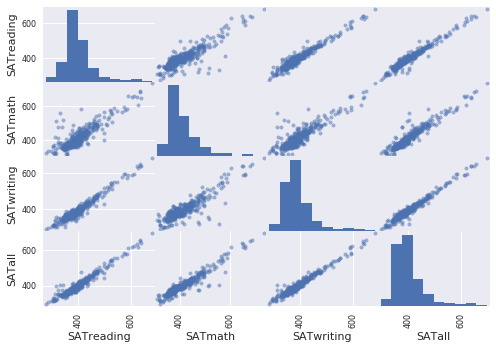

In [103]:
pd.scatter_matrix(sat_big[['SATreading', 'SATmath','SATwriting', 'SATall']], diagonal='hist')
plt.show()

### Figure 6. 
Scatter matrix of SAT features. Each numeric column is plotted against each other one. On the diagonal, a histogram of this feature is shown. 

There are some obvious patterns:  SAT features relate to each other in a linear fashion, which is not surprising.  So each SAT feature has a strong linear relationship with other SAT features.

# FBB ok, so ?  at this point you should identify that it is pointless to model both, cause they re very strongly collinear, and you should choose to carry on with SAT average since averaging removes some noise

 ### 6.2 plot the SAT feature by PUMA against 3 of the crime features(Major N, AvgOfNoCrim N, AvgOfMajor N)

From 6.1, we can know that all the SAT features are strongly linear correlated with each other, the plot of any SAT feature against crime would be identical. So I only use SATall in 6.2. The plot of any other SAT feature against crime should roughly be the same.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


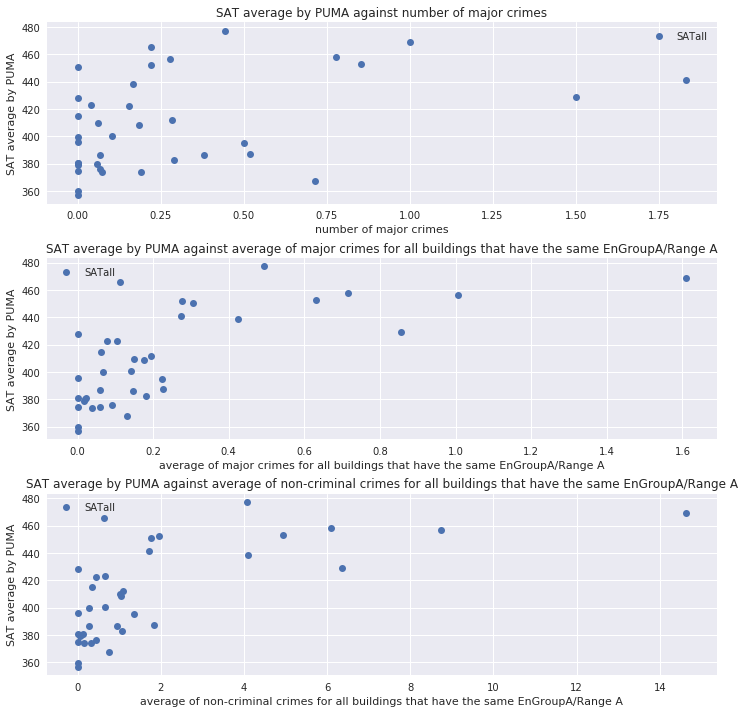

In [104]:
plt.figure(figsize=(12,12))
plt.plot([3,1])
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.subplot(311)
plt.plot(alldata_income['Major N'], alldata_income['SATall'],'o', label='SATall')
plt.title('SAT average by PUMA against number of major crimes')
plt.xlabel('number of major crimes')
plt.ylabel('SAT average by PUMA')
plt.legend()
plt.subplot(312)
plt.plot(alldata_income['AvgOfMajor N'], alldata_income['SATall'],'o', label='SATall')
plt.title('SAT average by PUMA against average of major crimes for all buildings that have the same EnGroupA/Range A')
plt.xlabel('average of major crimes for all buildings that have the same EnGroupA/Range A')
plt.ylabel('SAT average by PUMA')
plt.legend()
plt.subplot(313)
plt.plot(alldata_income['AvgOfNoCrim N'], alldata_income['SATall'],'o', label='SATall')
plt.title('SAT average by PUMA against average of non-criminal crimes for all buildings that have the same EnGroupA/Range A')
plt.xlabel('average of non-criminal crimes for all buildings that have the same EnGroupA/Range A')
plt.ylabel('SAT average by PUMA')
plt.legend()

### Figure 7.
Scatter plot of 'SATall' against Major N/  AvgOfMajor N/ AvgOfNoCrim N, averaged on PUMA level. 

Again, as the average number of crime goes higher, the average SAT score also fluctuates at a higher range.

### 6.3 Plot the SAT feature against medical data (asthmaRatio, drugsRatio)

Again, since all the SAT features have a strong linear relationship with each other, the plot of any other SAT feature against crime should roughly be the same.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


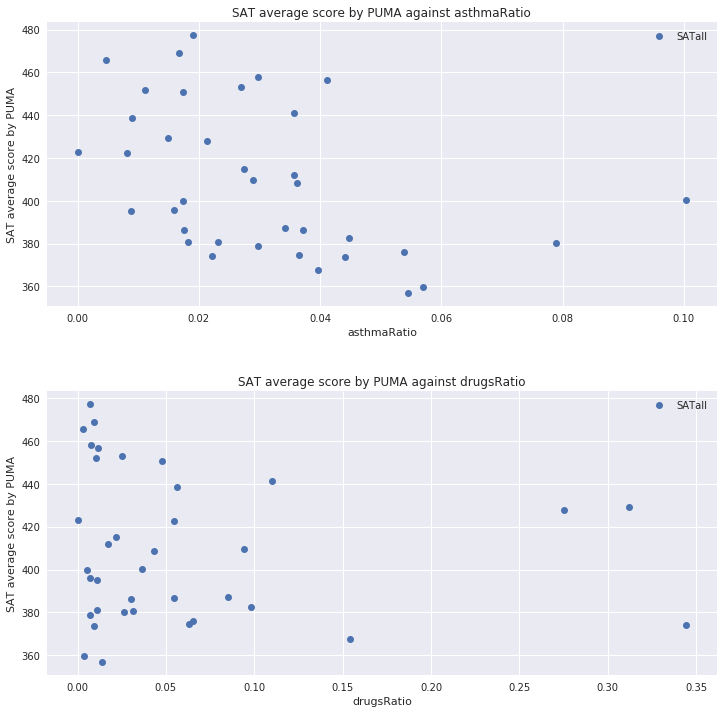

In [105]:
plt.figure(figsize=(12,12))
plt.plot([2,1])
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.subplot(211)
plt.plot(alldata_income['asthmaRatio'], alldata_income['SATall'],'o', label='SATall')
plt.title('SAT average score by PUMA against asthmaRatio')
plt.xlabel('asthmaRatio')
plt.ylabel('SAT average score by PUMA')
plt.legend()
plt.subplot(212)
plt.plot(alldata_income['drugsRatio'], alldata_income['SATall'],'o', label='SATall')
plt.title('SAT average score by PUMA against drugsRatio')
plt.xlabel('drugsRatio')
plt.ylabel('SAT average score by PUMA')
plt.legend()

### Figure 8.

Scatter plot of 'SATall' against asthmaRatio / drugsRatio, averaged on PUMA level. 

It is hard to see the relationship between SAT score and asthmaRatio / drugsRatio from this scatter plot

### Plot the SAT feature against income

In [106]:
alldata_income['B19113G_001E'] = alldata_income['B19113G_001E'].astype(float)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


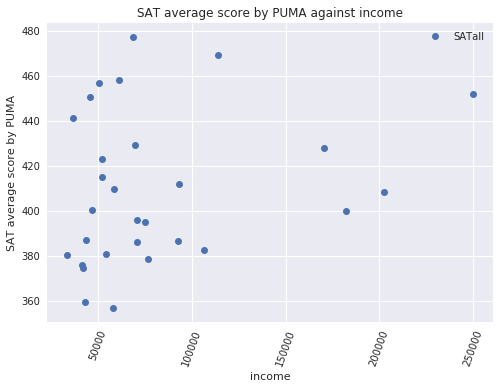

In [107]:
plt.plot(alldata_income['B19113G_001E'], alldata_income['SATall'],'o', label='SATall')
plt.title('SAT average score by PUMA against income')
plt.xticks(rotation=70)
plt.xlabel('income')
plt.ylabel('SAT average score by PUMA')
plt.legend()

### Figure 9.
Scatter plot of 'SATall' against income, averaged on a PUMA level.
As the income goes higher, the average SAT score also fluctuates at a higher range. This makes sense in the real world: Rich people would provide a better education environment for their next generation.

# FBB ok. task 6 10/10

### Extra Credit: plot a covariance matrix of all features

### Because the correlation of a variable with itself is always 1, but the covariance of itself is the square of std. I think the correlation matrix is more informative

In [110]:
schoolfeatures = alldata[['AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'SATmath', 'SATall', 'asthmaRatio', 'drugsRatio']]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


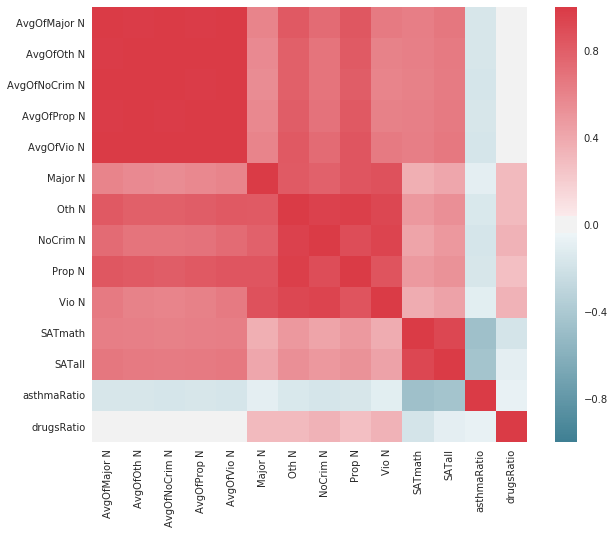

In [111]:
f, ax = plt.subplots(figsize=(10, 8))
corr = schoolfeatures.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Figure 10.
correlation matrix of all features: The correlations among 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', and  'AvgOfVio N' are all very high. Similarly, 

The correlations among 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N' are also high.

SAT math score and SAT average score have negative correlations with asthma ratio, which means that places with better SAT performances would have less asthma ratio. Probably because places with better education environment usually have less air pollution, so these places have less asthma ratio. It is hard to see a linear correlation between drugsRatio and any other feature from this matrix.

# FBB "Probably because places with better education environment usually have less air pollution, " this is entirely speculative! the things to say here would be that the features are collinear in bloclk, so creating a model which includes more than one of the colllinear features, as we will do, is problematc. 

# FBB excellent idea to plot this with a divergent color map and to make sure that the 0 is in the center

## 7. Mapping

When calculating the mean of each feature per puma, the geometry, latitude, and longitude were all dropped. In order to plot choropleths, I have to merge the geometry column back. 

In [112]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
index_left,,,,
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,..."
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,..."
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,..."


In [113]:
allfeature_geometry = gpd.GeoDataFrame(alldata_income.merge(pumashp, on='puma', copy=False, how='inner'))

In [114]:
len(alldata_income)

37

In [115]:
len(allfeature_geometry)

37

After I merge the pumashp geodataframe with the alldata_income dataframe, the length of the file does not change. This indicates that each puma in my alldata_income file can find its' polygon in the pumashp file. 

### the SAT features/ SAT math and SAT average score choropleths

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(905464.7392303485, 1075092.8783844009, 112560.52270721845, 278910.41073156259)

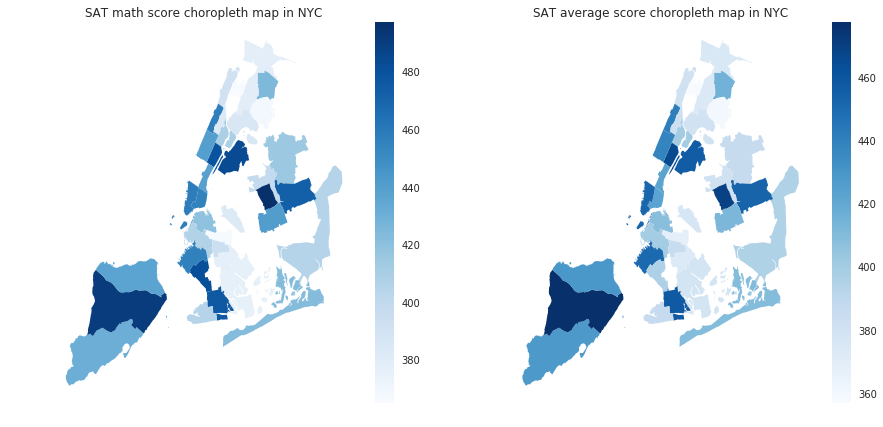

In [116]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax1.set_title('SAT math score choropleth map in NYC')
allfeature_geometry.plot(column='SATmath', ax=ax1, cmap='Blues', legend=True)
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.set_title('SAT average score choropleth map in NYC')
allfeature_geometry.plot(column='SATall', ax=ax2, cmap='Blues', legend=True)
ax2.axis('off')


### Figure 11.
From the correlation matrix and the scatter matrix, it is obvious that 'SAT math' and 'SATall' are linearly correlated with each other, so the choropleth maps of SAT features are similar.

# FBB what about the wholes in the map? missing pumas?

### The 3 chosen school crime features (Major N, AvgOfNoCrim N, AvgOfMajor N)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(905464.73923034826,
 1075092.8783844009,
 112560.52270721846,
 278910.41073156259)

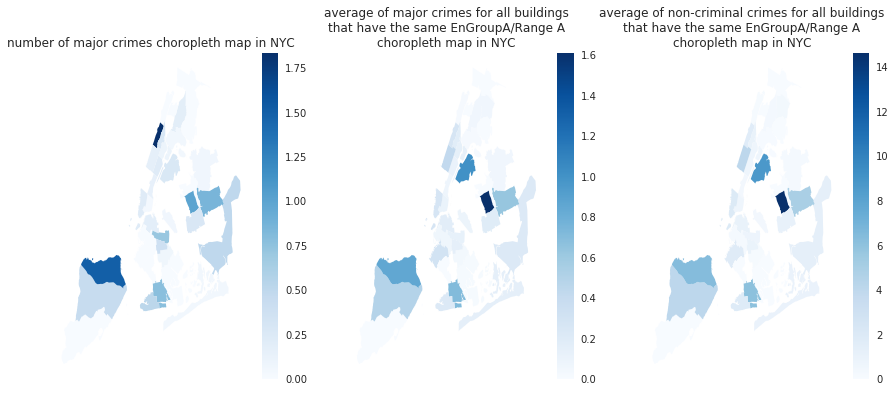

In [117]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(131)
ax1.set_title('number of major crimes choropleth map in NYC')
allfeature_geometry.plot(column='Major N', ax=ax1, cmap='Blues', legend=True)
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.set_title('average of major crimes for all buildings\nthat have the same EnGroupA/Range A\nchoropleth map in NYC')
allfeature_geometry.plot(column='AvgOfMajor N', ax=ax2, cmap='Blues', legend=True)
ax2.axis('off')

ax3 = fig.add_subplot(133)
ax3.set_title('average of non-criminal crimes for all buildings\nthat have the same EnGroupA/Range A\nchoropleth map in NYC')
allfeature_geometry.plot(column='AvgOfNoCrim N', ax=ax3, cmap='Blues', legend=True)
ax3.axis('off')

### Figure 12.

From the correlation matrix and the scatter matrix,'AvgOfNoCrim N' and 'AvgOfMajor N' are linearly correlated with each other, so the choropleth maps of them are similar. The relationship between 'Major N' and 'AvgOfNoCrim N'/'AvgOfMajor N' is not strong, so the choropleth maps are not similar. But it is still obvious that areas with high 'AvgOfNoCrim N'/'AvgOfMajor N' usually has high 'Major N' as well. 

### The two medical discharge fieatures and income from the extra credit

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(905464.73923034826,
 1075092.8783844009,
 112560.52270721846,
 278910.41073156253)

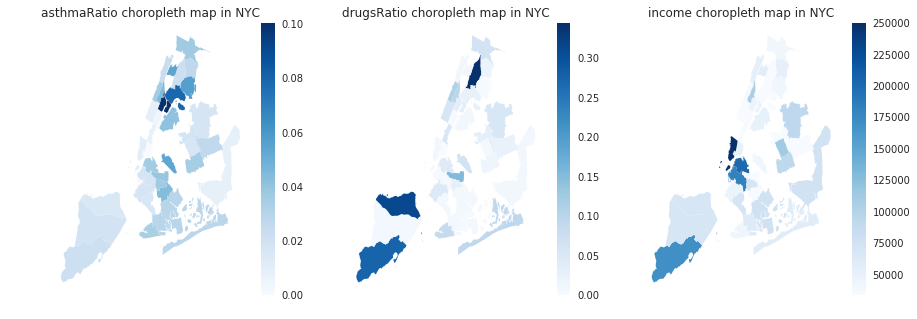

In [379]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax1.set_title('asthmaRatio choropleth map in NYC')
allfeature_geometry.plot(column='asthmaRatio', ax=ax1, cmap='Blues', legend=True)
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.set_title('drugsRatio choropleth map in NYC')
allfeature_geometry.plot(column='drugsRatio', ax=ax2, cmap='Blues', legend=True)
ax2.axis('off')

ax3 = fig.add_subplot(133)
ax3.set_title('income choropleth map in NYC')
allfeature_geometry.plot(column='B19113G_001E', ax=ax3, cmap='Blues', legend=True)
ax3.axis('off')

### Figure 13.
From the correlation matrix and the scatter matrix, 'asthmaRatio' and 'DrugsRatio' almost have no relationship with each other. So their choropleth maps look different. From the 'income' choropleth map, we can also derive that the relationship between 'income' and  'asthmaRatio' /'DrugsRatio'  is weak. 

# FBB task 7 9/10

## 8 Start with linear modeling

### Scale and preprocessing the data before modeling

Rename the columns, replace space with underscore

In [118]:
allfeature_geometry.rename(columns={'AvgOfMajor N': 'AvgOfMajor_N', 'AvgOfOth N': 'AvgOfOth_N', 'AvgOfNoCrim N': 'AvgOfNoCrim_N', 'AvgOfProp N': 'AvgOfProp_N',
       'AvgOfVio N': 'AvgOfVio_N', 'Major N': 'Major_N', 'Oth N': 'Oth_N', 
                                    'NoCrim N': 'NoCrim_N', 'Prop N': 'Prop_N', 'Vio N': 'Vio_N',}, inplace = True)

Fill the missing values in the income column before prepossessing or modeling. I use the method 'pad' since neighborhood places tend to have similar incomes. 

In [119]:
data_model = allfeature_geometry[['AvgOfMajor_N', 'AvgOfOth_N', 'AvgOfNoCrim_N', 'AvgOfProp_N',
       'AvgOfVio_N', 'Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N',
       'SATmath', 'SATall', 'asthmaRatio', 'drugsRatio', 'B19113G_001E']].fillna(method='pad')

Since the data here are all on different scales, scale the data is necessary here. Scale along the column.

In [120]:
data_model_scaled = pd.DataFrame(columns=data_model.columns, data=preprocessing.scale(data_model))

Since I am doing a multivariate-linear model in task 8 and 9, if I whiten my data, it would be hard for me to see the linear relationship between SAT score and other features.

So I just scale the data for task 8 and 9. I will whiten my data for task 10 and 11. 

### 8.1 Create a multivariate-linear model using all 10 of crime features, predicting SAT all.

Here I chose the SAT average score (SAT all) as my dependent variable. Again, all the SAT features are linear correlated, so it does not matter which feature I chose. They will be the same in the multivariate - linear model.

In [121]:
m1 = smf.ols(formula='SATall~AvgOfMajor_N+AvgOfOth_N+AvgOfNoCrim_N+AvgOfProp_N+AvgOfVio_N+Major_N+Oth_N+NoCrim_N+Prop_N+Vio_N', data=data_model_scaled).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     3.066
Date:                Mon, 17 Dec 2018   Prob (F-statistic):             0.0105
Time:                        18:32:17   Log-Likelihood:                -38.090
No. Observations:                  37   AIC:                             98.18
Df Residuals:                      26   BIC:                             115.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      6.072e-16      0.133   4.57e-15      1.000        -0.273     0.273
AvgOfMajor_N      1.2803      6.803      0.188      0.852       -12.704    15.265
AvgOfOth_N       -0.3689     13.449     -0.027      0.978       -28.013    27.275
AvgOfNoCrim_N    -2.5930      3.621     -0.716      0.480       -10.037     4.851
AvgOfProp_N       0.4128     11.974      0.034      0.973       -24.200    25.025
AvgOfVio_N        2.2171      7.371      0.301      0.766       -12.933    17.368
Major_N           0.8104      0.670      1.210      0.237        -0.566     2.187
Oth_N             2.4347      2.574      0.946      0.353        -2.857     7.727
NoCrim_N          0.0265      0.668      0.040      0.969        -1.346     1.399
Prop_N           -2.3082      1.850     -1.248      0.223        -6.110     1.494
Vio_N            -1.3391      1.211     -1.106      0.279        -3.828     1.150
==============================================================================
Omnibus:                        6.484   Durbin-Watson:                   1.298
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.182
Skew:                           0.875   Prob(JB):                       0.0749
Kurtosis:                       3.549   Cond. No.                         424.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Discuss the model summary

Is my model "close enough" to my observations? - this can be answered by R^2 and chi^2. The first is used in absence of measurement uncertainties, the latter is used when I can quantify the uncertainty in measurements. I think it is irrational to decide the distribution of features like 'AvgOfMajor_N'. Thus, I cannot measure the uncertainties/errors. So I am not using Chi ^2 to assess my models.

R^2 is the fraction of variance in the data explained by the model, for a perfect model it is R^2=1. ~0.5 is generally acceptable in social sciences, >0.8 in physical sciences. 

Here the R-squared is 0.541, since this is social science, I would say this model is acceptable.


### 8.2 add drugs and asthma discharge data and create a new multilinear model

In [122]:
m2 = smf.ols(formula='SATall~asthmaRatio+drugsRatio+AvgOfMajor_N+AvgOfOth_N+AvgOfNoCrim_N+AvgOfProp_N+AvgOfVio_N+Major_N+Oth_N+NoCrim_N+Prop_N+Vio_N', data=data_model_scaled).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     4.202
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00135
Time:                        18:33:56   Log-Likelihood:                -31.562
No. Observations:                  37   AIC:                             89.12
Df Residuals:                      24   BIC:                             110.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      6.072e-16      0.116   5.24e-15      1.000        -0.239     0.239
asthmaRatio      -0.3785      0.122     -3.110      0.005        -0.630    -0.127
drugsRatio       -0.1168      0.144     -0.811      0.425        -0.414     0.181
AvgOfMajor_N      2.4534      6.101      0.402      0.691       -10.137    15.044
AvgOfOth_N       -1.1752     11.987     -0.098      0.923       -25.914    23.564
AvgOfNoCrim_N    -1.9501      3.233     -0.603      0.552        -8.623     4.723
AvgOfProp_N       1.0905     10.637      0.103      0.919       -20.863    23.044
AvgOfVio_N        0.3026      6.544      0.046      0.964       -13.204    13.809
Major_N           0.9227      0.588      1.569      0.130        -0.291     2.137
Oth_N             3.3582      2.279      1.473      0.154        -1.346     8.062
NoCrim_N         -0.1945      0.587     -0.331      0.743        -1.406     1.017
Prop_N           -2.7754      1.624     -1.709      0.100        -6.127     0.576
Vio_N            -1.5143      1.065     -1.422      0.168        -3.712     0.683
==============================================================================
Omnibus:                        4.934   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.831
Skew:                           0.774   Prob(JB):                        0.147
Kurtosis:                       3.300   Cond. No.                         435.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Discuss the model summary

The second model has 10 crime features and 'asthmaRatio' and 'drugsRatio'.
The R-squared is now 0.678, much better than the first model, which is not surprising because I added two predictors to the model. To better compare these two models, I have to compare the adjusted R-squared values to find out! 

The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. Here the adjusted R-square of the second model is much better than that of the first one. 
So this model is more acceptable than the first one.

According to the confidence interval of the coefficient of 'asthmaRatio' and 'drugsRatio', the 'asthmaRatio' has a negative correlation with SAT score, so including 'asthmaRatio' to my model improves the model.  However, 'drugsRatio' is useless when predicting SAT scores. This conclusion is also consistent with the correlation matrix in task 6.

Pros: more predictive than the former one. 

Cons: including 'drugsratio' is redundant

# FBB how can you conclude that? you should include this info
# FBb good tho
# task 8 10/10

### Extra credit: Add income data and create a new multilinear model

In [123]:
m3 = smf.ols(formula='SATall~B19113G_001E+asthmaRatio+drugsRatio+AvgOfMajor_N+AvgOfOth_N+AvgOfNoCrim_N+AvgOfProp_N+AvgOfVio_N+Major_N+Oth_N+NoCrim_N+Prop_N+Vio_N', data=data_model_scaled).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     3.719
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00294
Time:                        18:34:51   Log-Likelihood:                -31.559
No. Observations:                  37   AIC:                             91.12
Df Residuals:                      23   BIC:                             113.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      6.072e-16      0.118   5.13e-15      1.000        -0.245     0.245
B19113G_001E     -0.0109      0.172     -0.063      0.950        -0.368     0.346
asthmaRatio      -0.3810      0.130     -2.927      0.008        -0.650    -0.112
drugsRatio       -0.1143      0.152     -0.750      0.461        -0.430     0.201
AvgOfMajor_N      2.6715      7.125      0.375      0.711       -12.067    17.410
AvgOfOth_N       -1.1579     12.246     -0.095      0.925       -26.491    24.176
AvgOfNoCrim_N    -1.9166      3.345     -0.573      0.572        -8.836     5.003
AvgOfProp_N       1.1220     10.876      0.103      0.919       -21.377    23.621
AvgOfVio_N       -0.0022      8.246     -0.000      1.000       -17.060    17.056
Major_N           0.9257      0.603      1.536      0.138        -0.321     2.172
Oth_N             3.3661      2.331      1.444      0.162        -1.457     8.189
NoCrim_N         -0.1808      0.638     -0.283      0.779        -1.501     1.139
Prop_N           -2.7836      1.664     -1.673      0.108        -6.225     0.658
Vio_N            -1.5241      1.099     -1.387      0.179        -3.797     0.749
==============================================================================
Omnibus:                        4.939   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.847
Skew:                           0.776   Prob(JB):                        0.146
Kurtosis:                       3.292   Cond. No.                         438.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Discuss the model summary

The R-squared of the third model is also 0.678, the same as the second one. The adjusted R-squared decreases. 
This implicates that the Income variable is helping, adding 'income'(B19113G_001E)  does not improve my model at all.  In fact, the coefficient of income in the model is close to zero, so income as almost nothing to do with SAT score. This result is also consistent with the choropleth map above. 

## 9 compare the linear models with LR test

Here I use the likelihood ratio test because they are nested models

H0: "the simpler model (m1) is preferable".

The difference in the number of degrees of freedom is 2, so the LR statistics will follow a $\chi^2$ distribution with 2 DOF.

In [124]:
m2.compare_lr_test(m1)

(13.055031982151739, 0.0014626345383195955, 2.0)

In [125]:
alpha = 0.05
print ("LR : ", -2 * (m1.llf - (m2.llf)))
print ("LR from statsmodels:", m2.compare_lr_test(m1))
LR = m2.compare_lr_test(m1)


LR :  13.0550319822
LR from statsmodels: (13.055031982151739, 0.0014626345383195955, 2.0)


I reject the Null hypothesis that the restricted model (m1) is better than m2 with p-value p<0.05. So m2 is the better model here.

# FBB so which model is better? why not saying that the model that includes asthma and drugs is better? etc

### Extra Credit part: compare m3 model (the one has income) with m2

In [126]:
m3.compare_lr_test(m2)

(0.0064101758634151906, 0.9361866935378047, 1.0)

Here I use the Likelihood Ratio test to compare m3 and m2. 

H0: m2 (the simpler model) is better

Ha: m3 is better.

The p-value is larger than 0.05, so I can not reject the null hypothesis. So the best model is m2 (12 features without income )

# FBB ok task 9 10/10

## 10 Random forest regression on school-related data only

### 10.1 Create a random forest model using only the crime in school data, but using all 10 crime in school features

### Whiten my data before modeling is necessary because the linear relationship among different kinds of crimes are obvious.
### Note that since I whitened the data, the features are not simply a kind of crime anymore, it is a combination of crimes.

# FBB I am concerned that you whitened data that wsa scaled already. I think doing both messes up the feature space. Your model is really poor, worse than mine, and the income becomes unimportant, while for me it was the best predictor

In [127]:
data_model_scaled.head()

,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,SATmath,SATall,asthmaRatio,drugsRatio,B19113G_001E
0,-0.720132,-0.643810,-0.621060,-0.668616,-0.690382,-0.706462,-0.678633,-0.632116,-0.666640,-0.674114,-1.128939,-1.023937,0.313133,0.058386,-0.723337
1,-0.533870,-0.494279,-0.504934,-0.500928,-0.520581,-0.706462,0.052281,-0.344178,-0.081019,0.043831,0.038033,0.164719,-0.138621,-0.445099,-0.532092
2,-0.544904,-0.506311,-0.511211,-0.515196,-0.531942,-0.249340,-0.178863,-0.111329,-0.332195,-0.045912,-1.114697,-1.043801,-0.404635,3.443848,-0.532092
3,-0.720132,-0.643810,-0.621060,-0.668616,-0.690382,-0.706462,-0.678633,-0.632116,-0.666640,-0.674114,-1.473781,-1.552967,1.207897,-0.540607,-0.418247
4,-0.720132,-0.643810,-0.621060,-0.668616,-0.690382,-0.706462,-0.678633,-0.632116,-0.666640,-0.674114,-1.391528,-1.465981,1.335167,-0.659997,-0.709953


In [128]:
X_scaled = data_model_scaled[['AvgOfMajor_N', 'AvgOfOth_N', 'AvgOfNoCrim_N', 'AvgOfProp_N',
       'AvgOfVio_N', 'Major_N', 'Oth_N', 'NoCrim_N', 'Prop_N', 'Vio_N']]
y_scaled = data_model_scaled['SATall']

In [129]:
pca = PCA(whiten=True)

In [130]:
data_model_scaled_whiten_1_X = pd.DataFrame(columns=[str(i) for i in range(10)], data=pca.fit_transform(X_scaled))

In [131]:
data_model_scaled_whiten_1_X.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.732258,0.090419,-0.202455,-0.249105,0.083416,-0.148473,-0.895239,0.389198,-0.359087,0.072431
1,-0.389666,-0.300644,-0.975551,-0.785509,3.015810,-0.129075,-0.274546,-0.174801,-0.282075,0.698100
2,-0.392675,-0.440018,-0.408114,0.051564,0.308778,-0.353248,-0.422087,1.117998,0.417784,0.173252
3,-0.732258,0.090419,-0.202455,-0.249105,0.083416,-0.148473,-0.895239,0.389198,-0.359087,0.072431
4,-0.732258,0.090419,-0.202455,-0.249105,0.083416,-0.148473,-0.895239,0.389198,-0.359087,0.072431


In [132]:
X_train, X_test, y_train, y_test = train_test_split(data_model_scaled_whiten_1_X, y_scaled, test_size=0.3)

regr = rfr()
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [133]:
y_pred = regr.predict(X_test)

### Measure the model performance

In [134]:
regr.score(X_test, y_test)

0.093943458694871751

In [135]:
regr.score(X_train, y_train)

0.75111384714739526

The score is the coefficient of determination R^2 of the prediction. In the train set, the score is 0.75; In the test set, the score is 0.09. The model performs much better on the train set than on the test set, which implicates that the model is overfitting the training dataset.

### 10.2 measure the feature importance of the features in this model to select the 3 most predictive features

In [136]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    plt.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    plt.xlim([-1, indices.shape[0]])
    plt.show()

In [137]:
regr.feature_importances_

array([ 0.37623455,  0.15843544,  0.01128082,  0.04869908,  0.01059151,
        0.04129853,  0.12369958,  0.09304894,  0.06528748,  0.07142407])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


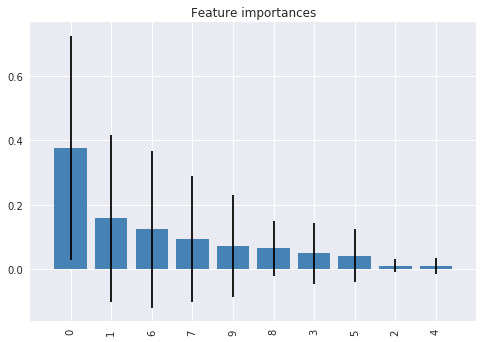

In [138]:
featureImportancePlot(regr, [str(i) for i in range(10)])

### Figure 14.
According to the feature importance array, the top three most important features are: the 0th, the 1st, and the 6th. 

Since I whitened the data before modeling, the features are now, in fact, a combination of crimes. I am unable to tell what is the most important kind of crime anymore.

# FBB correct. If you want to study feature importance you should not whiten. 
# But the uncertainty (plotted is the 1-sigma uncertainty) in the feature importance indicated that all features are consistent with each other, i.e. you cannot tell from this model which is most important. Also they are consistent with 0, i.e. you an throw them away and the model is just fine. You cannot do feature importance with bad models. 

The difference between the feature importance is obvious, the last two is not important at all. And the first one is significantly much more important than any other features. 

The specific combinations are as follows: 

In [150]:
pd.DataFrame(pca.components_, columns=X_scaled.columns, 
                    index=['PC-0', 'PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7', 'PC-8', 'PC-9']).iloc[[0,1,6]]

,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N
PC-0,0.329278,0.322971,0.321459,0.324748,0.329981,0.270312,0.330842,0.305860,0.330605,0.290183
PC-1,0.266204,0.311662,0.321423,0.298244,0.263074,-0.436032,-0.222816,-0.327409,-0.167012,-0.442348
PC-6,0.519823,-0.115260,-0.731072,0.159383,0.209742,0.034717,0.250776,-0.072970,-0.178529,-0.106523


## 11. Random forest with crime and medical (and income) features

### 11.1 create a random forest model that only uses the 3 most predictive features about school crimes and the health features (and income)

### Combine the 3 most predictive features about school crimes and the health features and income

In [151]:
data_model_scaled_2_x = pd.concat([data_model_scaled_whiten_1_X[['0','1','6']], data_model_scaled[['asthmaRatio', 'drugsRatio', 'B19113G_001E']]], axis=1)
y_2 = data_model_scaled['SATall']

### Whiten the data again

In [152]:
pca = PCA(whiten=True)

In [153]:
data_model_scaled_whiten_2_X = pd.DataFrame(columns=[str(i) for i in range(6)], data=pca.fit_transform(data_model_scaled_2_x))

In [154]:
data_model_scaled_whiten_2_X.head()

,0,1,2,3,4,5
0,0.175176,-0.879590,-0.736986,0.570315,0.033395,-0.334366
1,0.178152,-0.427481,-0.355907,0.192591,-0.585052,0.498868
2,-2.150042,-0.612520,-0.197418,0.607085,-0.069713,-3.262494
3,0.634236,-1.174875,-0.406496,0.455883,0.796973,0.417698
4,0.743936,-1.380013,-0.509240,0.283337,0.714971,0.441656


In [155]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_model_scaled_whiten_2_X, y_2, test_size=0.3)

regr_2 = rfr()
regr_2.fit(X_train_2, y_train_2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [156]:
y_pred_2 = regr_2.predict(X_test_2)

### 11.2 evaluate the performance of the model

In [157]:
regr_2.score(X_test_2, y_test_2)

0.48501884960759445

In [158]:
regr_2.score(X_train_2, y_train_2)

0.88549008665632634

In the train set, the score is 0.88; In the test set, the score is 0.48. The model performs much better on the train set than on the test set, which implicates that the model is overfitting the training dataset. But this model is much better than the previous one.

### 11.3 discuss the importance of each feature in the model

In [159]:
regr_2.feature_importances_

array([ 0.09491781,  0.36499171,  0.08305819,  0.25454185,  0.14021625,
        0.06227419])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


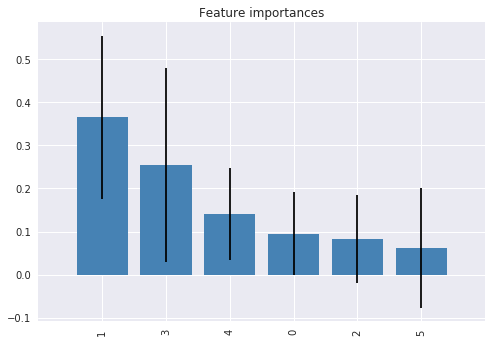

In [160]:
featureImportancePlot(regr_2, labels=[str(i) for i in range(6)])

### Figure 15.
According to the feature importance array, the top three most important features are: the 1st, the 3rd, and the 4th.
Since I whitened the data before modeling, the features here are also a combination of different kinds of crimes, 'asthmaRatio', 'drugsRatio', and income. 

# FBB same: the feature importance cannot be established, the uncertainty makes all features consistent

The specific combinations are:

In [163]:
pd.DataFrame(pca.components_, columns=data_model_scaled_2_x.columns,
                    index=['PC-0', 'PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5']).iloc[[1,3,4]]

,0,1,6,asthmaRatio,drugsRatio,B19113G_001E
PC-1,0.412886,0.353291,0.134181,-0.611109,-0.077141,0.554348
PC-3,-0.753516,-0.024004,-0.426758,-0.226353,0.069034,0.439900
PC-4,0.295286,0.259276,-0.382401,0.673374,0.154521,0.471213


The difference between the feature importance is not as obvious as the previous one. (This makes sense because I already filtered out the not important features previously)

# 1 10/10
# 2 10/10
# 3 10/10
# 4 10/10
# 5 10/10
# 6 10/10
# 7 10/10
# 8 10/10
# 9 10/10
# 10 7/10
# 11 7/10

# good!

# total 100/100